# MLP BASED Discrete Variational Autoencoders

2025-09-13 11:42:32.409820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757763752.435708    4646 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757763752.443839    4646 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1: Train ELBO=-196.7117, Test ELBO=-177.2235
Epoch 2: Train ELBO=-175.3224, Test ELBO=-172.6211
Epoch 3: Train ELBO=-171.4577, Test ELBO=-171.2067
Epoch 4: Train ELBO=-169.5231, Test ELBO=-168.9597
Epoch 5: Train ELBO=-164.7906, Test ELBO=-160.5120
Epoch 6: Train ELBO=-155.9139, Test ELBO=-151.4165
Epoch 7: Train ELBO=-149.5115, Test ELBO=-148.2002
Epoch 8: Train ELBO=-144.2135, Test ELBO=-141.0227
Epoch 9: Train ELBO=-138.8545, Test ELBO=-135.9734
Epoch 10: Train ELBO=-135.2841, Test ELBO=-133.9221
Epoch 11: Train ELBO=-132.8133, Test ELBO=-132.2820
Epoch 12: Train ELBO=-130.7850, Test ELBO=-129.5718
Epoch 13: Train ELBO=-129.2995, Test ELBO=-127.3998
Epoch 14: Train ELBO=-127.4914, Test ELBO=-126.1793
Epoch 15: Train ELBO=-125.8637, Test ELBO=-125.3770
Epoch 16: Train ELBO=-125.4014, Test ELBO=-125.2907
Epoch 17: Train ELBO=-124.2017, Test ELBO=-124.3717
Epoch 18: Train ELBO=-123.0805, Test ELBO=-122.7609
Epoch 19: Train ELBO=-122.7808, Test ELBO=-121.4481
Epoch 20: Train ELBO=

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP + KMeans clustering metrics: NMI=0.3888, ARI=0.2420


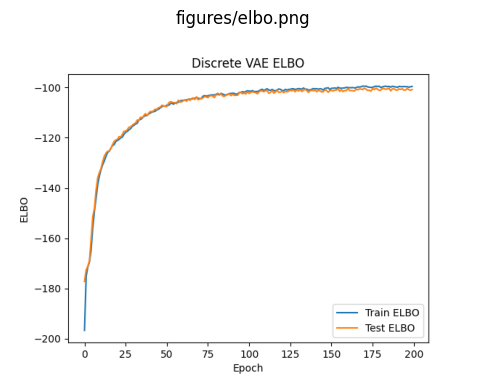

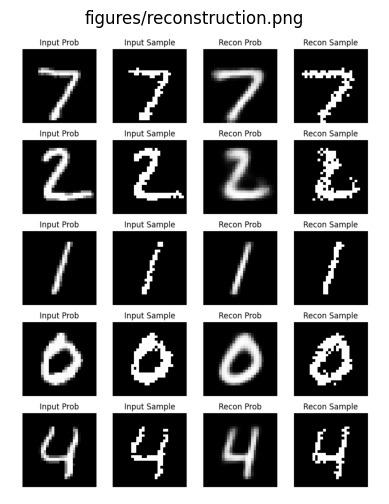

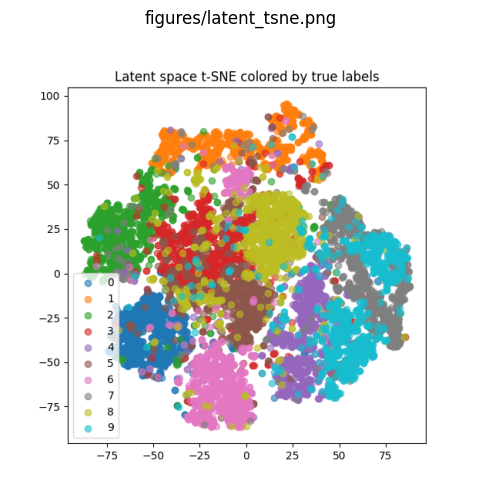

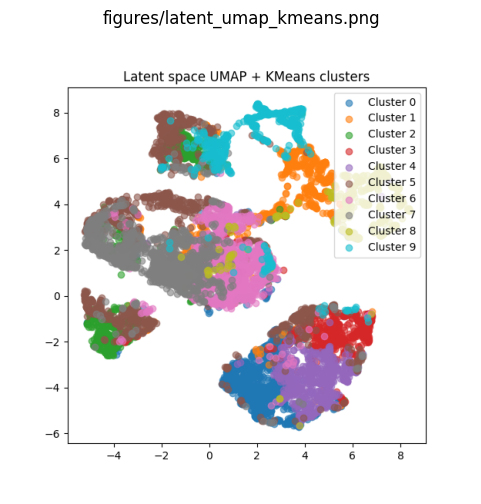

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import OneHotCategorical
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import umap

BATCH_SIZE = 128
EPOCHS = 200
LATENTS = 8
CATEGORIES = 16
TEMPERATURE = 0.5       # contrastive temperature
ALPHA_CONTRAST = 0.1    # weight for contrastive loss
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

# Data Loaders
def get_dataloaders(cuda, batch_size):
    kwargs = {'num_workers': 2, 'pin_memory': True} if cuda else {}
    train_loader = DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

# VAE Model
class VAE(nn.Module):
    def __init__(self, nlat=LATENTS, ncat=CATEGORIES):
        super(VAE, self).__init__()
        self.nlat = nlat
        self.ncat = ncat
        # Encoder
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, nlat*ncat)
        # Decoder
        self.fc4 = nn.Linear(nlat*ncat, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        logits = self.fc3(h).view(len(x), self.nlat, self.ncat)
        return F.softmax(logits, dim=-1)

    def sample(self, p):
        m = OneHotCategorical(p)
        return m.sample()

    def decode(self, z):
        h = F.relu(self.fc4(z.view(len(z), self.nlat*self.ncat)))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

# Contrastive Loss (InfoNCE)
def contrastive_loss(latents, labels, temperature=TEMPERATURE):
    latents = F.normalize(latents, dim=1)
    batch_size = latents.shape[0]
    sim_matrix = torch.matmul(latents, latents.T) / temperature
    mask = torch.eye(batch_size, device=latents.device).bool()
    sim_matrix.masked_fill_(mask, -9e15)
    labels = labels.unsqueeze(1)
    pos_mask = labels == labels.T
    log_prob = F.log_softmax(sim_matrix, dim=1)
    loss = -log_prob[pos_mask].mean()
    return loss

# Training & Testing
def train_epoch(model, loader, optimizer, alpha=ALPHA_CONTRAST):
    model.train()
    ELBO_total = 0
    for x, y in loader:
        x = x.to(DEVICE).view(-1, 784)
        y = y.to(DEVICE)
        x = torch.bernoulli(x)
        optimizer.zero_grad()

        p = model.encode(x)
        z = model.sample(p)
        x_recon = model.decode(z)

        # VAE loss
        BCE = F.binary_cross_entropy(x_recon, x, reduction='none').sum(-1)
        loss_decoder = -BCE.sum()
        entropy = torch.distributions.Categorical(p).entropy().sum()
        p_sampled = torch.masked_select(p, z == 1).view(p.shape[0], -1)
        B = 125
        expectation = torch.sum((BCE - B).detach() * torch.log(p_sampled).sum(-1))
        loss_encoder = entropy - expectation
        elbo_loss = loss_encoder + loss_decoder

        # Contrastive loss
        lat_flat = p.view(len(x), -1)
        cl_loss = contrastive_loss(lat_flat, y)
        loss = elbo_loss + alpha * cl_loss

        loss.backward()
        optimizer.step()
        ELBO_total += (entropy - model.nlat * math.log(model.ncat) - BCE.sum()).item()
    return ELBO_total / len(loader.dataset)

def test_epoch(model, loader):
    model.eval()
    running_ELBO = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE).view(-1, 784)
            x = torch.bernoulli(x)
            p = model.encode(x)
            z = model.sample(p)
            x_recon = model.decode(z)
            BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
            entropy = torch.distributions.Categorical(p).entropy().sum()
            ELBO = entropy - model.nlat * math.log(model.ncat) - BCE
            running_ELBO += ELBO.item()
    return running_ELBO / len(loader.dataset)

# Plotting & Latent Analysis
def plot_elbo(train_list, test_list):
    os.makedirs('figures', exist_ok=True)
    plt.plot(train_list, label='Train ELBO')
    plt.plot(test_list, label='Test ELBO')
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.legend()
    plt.title("Discrete VAE ELBO")
    plt.savefig('figures/elbo.png')
    plt.close()

def plot_reconstruction(model, loader, n_samples=5):
    model.eval()
    x_input, _ = next(iter(loader))
    x_input = x_input.to(DEVICE).view(-1, 784)
    x_input_binarized = torch.bernoulli(x_input)
    with torch.no_grad():
        p = model.encode(x_input_binarized)
        z = model.sample(p)
        x_recon = model.decode(z)

    os.makedirs('figures', exist_ok=True)
    fig, ax = plt.subplots(n_samples, 4, figsize=(8, n_samples*2))
    for i in range(n_samples):
        ax[i, 0].imshow(x_input[i].view(28,28).cpu(), cmap='gray')
        ax[i, 0].set_title("Input Prob")
        ax[i, 1].imshow(x_input_binarized[i].view(28,28).cpu(), cmap='gray')
        ax[i, 1].set_title("Input Sample")
        ax[i, 2].imshow(x_recon[i].view(28,28).cpu(), cmap='gray')
        ax[i, 2].set_title("Recon Prob")
        ax[i, 3].imshow(torch.bernoulli(x_recon[i]).view(28,28).cpu(), cmap='gray')
        ax[i, 3].set_title("Recon Sample")
        for j in range(4):
            ax[i,j].axis('off')
    plt.tight_layout()
    plt.savefig('figures/reconstruction.png')
    plt.close()

def latent_cluster_analysis(model, loader):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE).view(-1, 784)
            p = model.encode(x)
            latents.append(p.view(len(x), -1).cpu().numpy())
            labels.append(y.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    sil_score = silhouette_score(latents, labels)
    print("Silhouette Score (latent vs labels):", sil_score)

    plt.figure(figsize=(6,6))
    for i in range(10):
        idx = labels == i
        plt.scatter(latents_2d[idx,0], latents_2d[idx,1], label=str(i), alpha=0.6)
    plt.legend()
    plt.title("Latent space t-SNE colored by true labels")
    plt.savefig('figures/latent_tsne.png')
    plt.close()

def latent_umap_kmeans(model, loader, n_clusters=10):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE).view(-1, 784)
            p = model.encode(x)
            latents.append(p.view(len(x), -1).cpu().numpy())
            labels.append(y.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    reducer = umap.UMAP(n_components=2, random_state=42)
    latents_2d = reducer.fit_transform(latents)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(latents)

    nmi = normalized_mutual_info_score(labels, cluster_ids)
    ari = adjusted_rand_score(labels, cluster_ids)
    print(f"UMAP + KMeans clustering metrics: NMI={nmi:.4f}, ARI={ari:.4f}")

    plt.figure(figsize=(6,6))
    for i in range(n_clusters):
        idx = cluster_ids == i
        plt.scatter(latents_2d[idx,0], latents_2d[idx,1], label=f'Cluster {i}', alpha=0.6)
    plt.legend()
    plt.title("Latent space UMAP + KMeans clusters")
    plt.savefig('figures/latent_umap_kmeans.png')
    plt.close()

# Main
def main():
    train_loader, test_loader = get_dataloaders(CUDA, BATCH_SIZE)
    model = VAE().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, maximize=True)

    train_elbo_ls, test_elbo_ls = [], []
    for epoch in range(1, EPOCHS+1):
        train_elbo = train_epoch(model, train_loader, optimizer, alpha=ALPHA_CONTRAST)
        test_elbo = test_epoch(model, test_loader)
        train_elbo_ls.append(train_elbo)
        test_elbo_ls.append(test_elbo)
        print(f"Epoch {epoch}: Train ELBO={train_elbo:.4f}, Test ELBO={test_elbo:.4f}")

    torch.save(model.state_dict(), 'vae_contrastive.pt')
    plot_elbo(train_elbo_ls, test_elbo_ls)
    plot_reconstruction(model, test_loader)
    latent_cluster_analysis(model, test_loader)
    latent_umap_kmeans(model, test_loader)

if __name__ == '__main__':
    main()

# Show all figures
fig_files = [
    'figures/elbo.png',
    'figures/reconstruction.png',
    'figures/latent_tsne.png',
    'figures/latent_umap_kmeans.png'
]

for file in fig_files:
    if os.path.exists(file):
        img = plt.imread(file)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(file)
        plt.show()
    else:
        print(f"{file} not found!")


## CNN BASED Discrete Variational Autoencoders

In [ ]:
# CNN-VAE with Contrastive Loss
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import OneHotCategorical
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import umap

# Config
BATCH_SIZE = 128
EPOCHS = 200
LATENTS = 8
CATEGORIES = 16
TEMPERATURE = 0.5       # contrastive temperature
ALPHA_CONTRAST = 0.1    # weight for contrastive loss
FIG_DIR = "figures_cnn"
os.makedirs(FIG_DIR, exist_ok=True)

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")


# Data Loaders
def get_dataloaders(cuda, batch_size):
    kwargs = {'num_workers': 2, 'pin_memory': True} if cuda else {}
    transform = transforms.ToTensor()
    train_loader = DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

# CNN-based VAE
class VAE(nn.Module):
    def __init__(self, nlat=LATENTS, ncat=CATEGORIES):
        super(VAE, self).__init__()
        self.nlat = nlat
        self.ncat = ncat

        # Encoder: CNN feature extractor
        self.enc_conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.enc_fc = nn.Linear(128*7*7, nlat*ncat)

        # Decoder: Transposed CNN
        self.dec_fc = nn.Linear(nlat*ncat, 128*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1) # output

    def encode(self, x):
        x = x.view(-1, 1, 28, 28)
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = F.relu(self.enc_conv3(h))
        h = h.view(h.size(0), -1)
        logits = self.enc_fc(h).view(len(x), self.nlat, self.ncat)
        return F.softmax(logits, dim=-1)

    def sample(self, p):
        return OneHotCategorical(p).sample()

    def decode(self, z):
        h = self.dec_fc(z.view(len(z), -1))
        h = h.view(-1, 128, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        h = F.relu(self.dec_deconv2(h))
        return torch.sigmoid(self.dec_deconv3(h)).view(len(z), -1)


# Contrastive Loss (InfoNCE)
def contrastive_loss(latents, labels, temperature=TEMPERATURE):
    latents = F.normalize(latents, dim=1)
    sim_matrix = torch.matmul(latents, latents.T) / temperature
    mask = torch.eye(latents.size(0), device=latents.device).bool()
    sim_matrix.masked_fill_(mask, -9e15)
    labels = labels.unsqueeze(1)
    pos_mask = labels == labels.T
    log_prob = F.log_softmax(sim_matrix, dim=1)
    return -log_prob[pos_mask].mean()

# Training & Testing
def train_epoch(model, loader, optimizer, alpha=ALPHA_CONTRAST):
    model.train()
    ELBO_total = 0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        x = torch.bernoulli(x)
        optimizer.zero_grad()

        p = model.encode(x)
        z = model.sample(p)
        x_recon = model.decode(z)

        BCE = F.binary_cross_entropy(x_recon, x.view(-1, 28*28), reduction='none').sum(-1)
        loss_decoder = -BCE.sum()
        entropy = torch.distributions.Categorical(p).entropy().sum()
        p_sampled = torch.masked_select(p, z == 1).view(p.shape[0], -1)
        B = 125
        expectation = torch.sum((BCE - B).detach() * torch.log(p_sampled).sum(-1))
        loss_encoder = entropy - expectation
        elbo_loss = loss_encoder + loss_decoder

        # Contrastive loss
        lat_flat = p.view(len(x), -1)
        cl_loss = contrastive_loss(lat_flat, y)
        loss = elbo_loss + alpha * cl_loss

        loss.backward()
        optimizer.step()
        ELBO_total += (entropy - model.nlat * math.log(model.ncat) - BCE.sum()).item()
    return ELBO_total / len(loader.dataset)

def test_epoch(model, loader):
    model.eval()
    running_ELBO = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            x = torch.bernoulli(x)
            p = model.encode(x)
            z = model.sample(p)
            x_recon = model.decode(z)
            BCE = F.binary_cross_entropy(x_recon, x.view(-1, 28*28), reduction='sum')
            entropy = torch.distributions.Categorical(p).entropy().sum()
            ELBO = entropy - model.nlat * math.log(model.ncat) - BCE
            running_ELBO += ELBO.item()
    return running_ELBO / len(loader.dataset)

# Plotting & Analysis
def plot_elbo(train_list, test_list):
    plt.plot(train_list, label='Train ELBO')
    plt.plot(test_list, label='Test ELBO')
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.legend()
    plt.title("CNN-Discrete VAE ELBO")
    plt.savefig(os.path.join(FIG_DIR, 'elbo.png'))
    plt.close()

def plot_reconstruction(model, loader, n_samples=5):
    model.eval()
    x_input, _ = next(iter(loader))
    x_input = x_input.to(DEVICE)
    x_input_bin = torch.bernoulli(x_input)
    with torch.no_grad():
        p = model.encode(x_input_bin)
        z = model.sample(p)
        x_recon = model.decode(z)

    fig, ax = plt.subplots(n_samples, 4, figsize=(8, n_samples*2))
    for i in range(n_samples):
        ax[i, 0].imshow(x_input[i].view(28,28).cpu(), cmap='gray')
        ax[i, 1].imshow(x_input_bin[i].view(28,28).cpu(), cmap='gray')
        ax[i, 2].imshow(x_recon[i].view(28,28).cpu(), cmap='gray')
        ax[i, 3].imshow(torch.bernoulli(x_recon[i]).view(28,28).cpu(), cmap='gray')
        for j in range(4):
            ax[i,j].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'reconstruction.png'))
    plt.close()

def latent_cluster_analysis(model, loader):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            p = model.encode(x)
            latents.append(p.view(len(x), -1).cpu().numpy())
            labels.append(y.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    sil_score = silhouette_score(latents, labels)
    print("Silhouette Score (latent vs labels):", sil_score)

    plt.figure(figsize=(6,6))
    for i in range(10):
        idx = labels == i
        plt.scatter(latents_2d[idx,0], latents_2d[idx,1], label=str(i), alpha=0.6)
    plt.legend()
    plt.title("Latent space t-SNE colored by true labels")
    plt.savefig(os.path.join(FIG_DIR, 'latent_tsne.png'))
    plt.close()

def latent_umap_kmeans(model, loader, n_clusters=10):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            p = model.encode(x)
            latents.append(p.view(len(x), -1).cpu().numpy())
            labels.append(y.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    reducer = umap.UMAP(n_components=2, random_state=42)
    latents_2d = reducer.fit_transform(latents)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(latents)

    nmi = normalized_mutual_info_score(labels, cluster_ids)
    ari = adjusted_rand_score(labels, cluster_ids)
    print(f"UMAP + KMeans clustering metrics: NMI={nmi:.4f}, ARI={ari:.4f}")

    plt.figure(figsize=(6,6))
    for i in range(n_clusters):
        idx = cluster_ids == i
        plt.scatter(latents_2d[idx,0], latents_2d[idx,1], label=f'Cluster {i}', alpha=0.6)
    plt.legend()
    plt.title("Latent space UMAP + KMeans clusters")
    plt.savefig(os.path.join(FIG_DIR, 'latent_umap_kmeans.png'))
    plt.close()

def main():
    train_loader, test_loader = get_dataloaders(CUDA, BATCH_SIZE)
    model = VAE().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, maximize=True)

    train_elbo_ls, test_elbo_ls = [], []
    for epoch in range(1, EPOCHS+1):
        train_elbo = train_epoch(model, train_loader, optimizer)
        test_elbo = test_epoch(model, test_loader)
        train_elbo_ls.append(train_elbo)
        test_elbo_ls.append(test_elbo)
        print(f"Epoch {epoch}: Train ELBO={train_elbo:.4f}, Test ELBO={test_elbo:.4f}")

    torch.save(model.state_dict(), 'vae_cnn_contrastive.pt')
    plot_elbo(train_elbo_ls, test_elbo_ls)
    plot_reconstruction(model, test_loader)
    latent_cluster_analysis(model, test_loader)
    latent_umap_kmeans(model, test_loader)

if __name__ == '__main__':
    main()


Epoch 1: Train ELBO=-199.1212, Test ELBO=-184.3733
Epoch 2: Train ELBO=-184.4556, Test ELBO=-184.1998
Epoch 3: Train ELBO=-182.5655, Test ELBO=-179.3089
Epoch 4: Train ELBO=-160.3537, Test ELBO=-140.7039
Epoch 5: Train ELBO=-134.9669, Test ELBO=-129.3578
Epoch 6: Train ELBO=-125.7756, Test ELBO=-122.4175
Epoch 7: Train ELBO=-120.9333, Test ELBO=-118.8941
Epoch 8: Train ELBO=-117.5297, Test ELBO=-115.1362
Epoch 9: Train ELBO=-114.9041, Test ELBO=-113.1378
Epoch 10: Train ELBO=-113.4674, Test ELBO=-111.7207
Epoch 11: Train ELBO=-112.6567, Test ELBO=-110.8950
Epoch 12: Train ELBO=-111.0594, Test ELBO=-109.9794
Epoch 13: Train ELBO=-110.4194, Test ELBO=-109.5695
Epoch 14: Train ELBO=-109.3045, Test ELBO=-109.1659
Epoch 15: Train ELBO=-109.0456, Test ELBO=-109.5382
Epoch 16: Train ELBO=-108.2611, Test ELBO=-107.7940
Epoch 17: Train ELBO=-107.6980, Test ELBO=-106.6963
Epoch 18: Train ELBO=-107.1174, Test ELBO=-106.9803
Epoch 19: Train ELBO=-106.7336, Test ELBO=-106.0548
Epoch 20: Train ELBO=

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP + KMeans clustering metrics: NMI=0.3293, ARI=0.1838


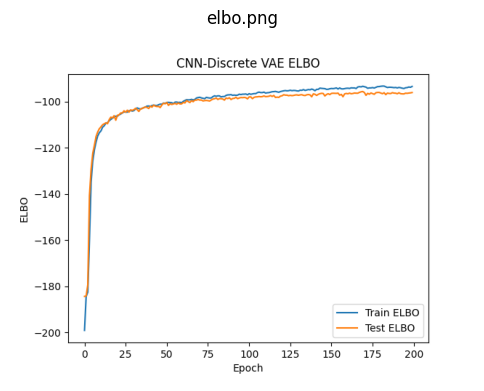

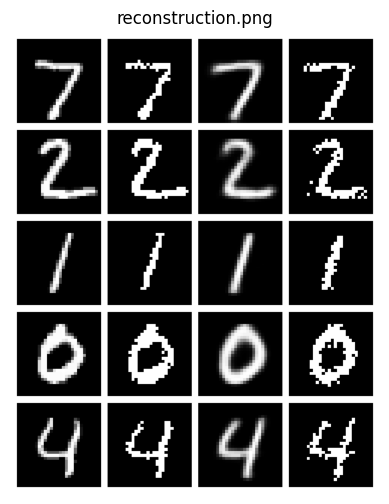

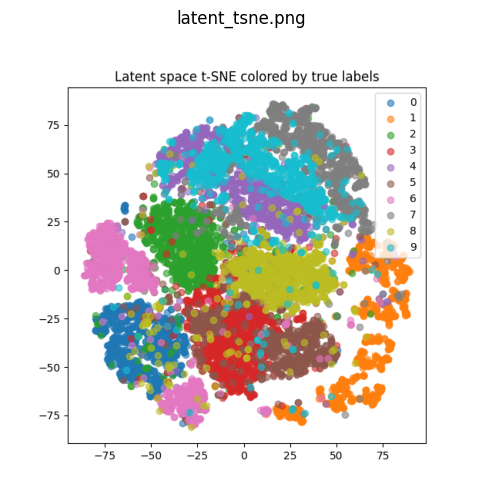

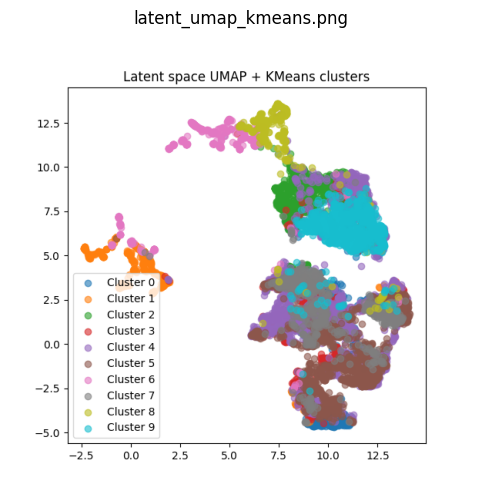

In [ ]:
# Show Saved Figures
import matplotlib.pyplot as plt
import os

FIG_DIR = "figures_cnn"
fig_files = [
    "elbo.png",
    "reconstruction.png",
    "latent_tsne.png",
    "latent_umap_kmeans.png"
]

for fname in fig_files:
    path = os.path.join(FIG_DIR, fname)
    if os.path.exists(path):
        img = plt.imread(path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname)
        plt.show()
    else:
        print(f"⚠️ {fname} not found in {FIG_DIR}")
